<a href="https://colab.research.google.com/github/Rohit1217/MADE/blob/main/made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch,torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms


In [365]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)

data_target=data*0.5+0.5
data=data.view(60000,784)
data=data.to(dtype=torch.float32)
data_target=data_target.view(60000,784)
#new_column = torch.full((60000, 1), 0)
#data = torch.cat((new_column, data[:, :-1]), dim=1)

trainset=TensorDataset(data,data_target)
trainloader=DataLoader(trainset,batch_size=256,shuffle=True)

In [69]:
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)
data_t=testset.data
data_t=data_t.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data_t=norm(data_t)
data_t=data_t.view(10000,784)
new_column = torch.full((10000, 1), 2)
data_t = torch.cat((new_column, data_t[:, :-1]), dim=1)

In [4]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [215]:
def masker(mask):
  out,inn=mask.shape
  stride=inn/out
  for i in range(out):

    for j in range(inn):
      if j>=(i)*stride:
        mask[i,j]=0
  return mask
x=torch.ones(5,5)
masker(x)

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]])

In [6]:
def mask(inn,out):
  mask=torch.ones(out,inn)
  return masker(mask)
#mask(5,5)

In [7]:
class MaskedLinear(nn.Module):
  def __init__(self,in_dim,out_dim):
    super(MaskedLinear,self).__init__()
    self.fc=nn.Linear(in_dim,out_dim)
    self.mask1=mask(in_dim,out_dim).to(get_device())
    self.register_buffer('mask',self.mask1)

  def forward(self,x):
    self.fc.weight.data*=self.mask
    return self.fc(x)


In [367]:
class Made(nn.Module):
  def __init__(self,latent_dim):
    super(Made,self).__init__()
    self.ldim=latent_dim
    self.fc1=MaskedLinear(784,latent_dim)
    self.ln1=nn.LayerNorm(latent_dim)
    self.fc2=MaskedLinear(latent_dim,784)
    self.ln2=nn.LayerNorm(784)
    self.ln3=nn.LayerNorm(784)
    self.fc3=MaskedLinear(784,784)
    self.fc4=MaskedLinear(784,784)

  def forward(self,x):
    #x=x+torch.arange(784).to(get_device())
    x=(F.gelu(self.fc1(x)))
    x=(F.gelu(self.fc2(x)))
    x=self.fc3(x)
    return x

In [ ]:
torch.arange(784)

In [368]:
lr_rate=0.001
epochs=100
model=Made(784)
model.to(get_device())
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=lr_rate)

In [369]:
loss_list=[]
for epoch in range(epochs):
  total_loss=0
  length=0
  for input,target in trainloader:
    input,target=input.to(get_device()),target.to(get_device())
    pred=F.sigmoid(model(input))
    loss=criterion(pred,target)

    total_loss+=loss.item()
    length+=1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'total_loss ={total_loss},avg_loss={total_loss/length},epoch={epoch}')

total_loss =65.3124200552702,avg_loss=0.27792519172455404,epoch=0
total_loss =45.57172390818596,avg_loss=0.193922229396536,epoch=1
total_loss =38.434158980846405,avg_loss=0.16354961268445278,epoch=2
total_loss =34.7601478099823,avg_loss=0.14791552259566937,epoch=3
total_loss =32.494305178523064,avg_loss=0.13827363905754494,epoch=4
total_loss =31.050043240189552,avg_loss=0.13212784357527468,epoch=5
total_loss =30.07455288618803,avg_loss=0.1279768207922895,epoch=6
total_loss =29.35208483785391,avg_loss=0.12490248867171876,epoch=7
total_loss =28.815344825387,avg_loss=0.12261848861866809,epoch=8
total_loss =28.3579540848732,avg_loss=0.12067214504201361,epoch=9
total_loss =27.984390899538994,avg_loss=0.11908251446612338,epoch=10
total_loss =27.685320876538754,avg_loss=0.11780987607037767,epoch=11
total_loss =27.44193198531866,avg_loss=0.11677417866093047,epoch=12
total_loss =27.208999790251255,avg_loss=0.1157829778308564,epoch=13
total_loss =27.032208874821663,avg_loss=0.11503067606307091,e

KeyboardInterrupt: 

In [ ]:
model.eval()
with torch.no_grad():
  x=data_t[9]
  #x[0]=0
  #x=torch.rand(784)
  x=x.to('cuda:0')
  x=F.sigmoid(model(x))
    #print(x[28*14:28*15])

  x=x.view(28,28)
  x=x.to('cpu')
  image_np = x.numpy()



  # Display the image using matplotlib
  plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
  plt.axis('off')  # Turn off axis labels
  plt.show()

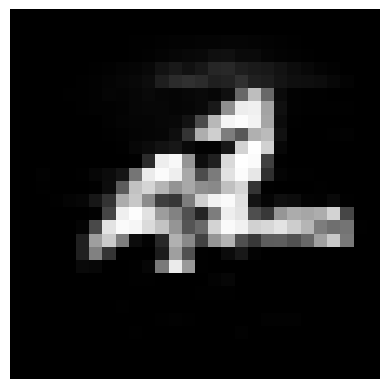

In [401]:
model.eval()
with torch.no_grad():
  x=torch.zeros(784)
  z=torch.zeros(784)
  #z=z.to('cuda:0')
  x=x.to(get_device())
  y=torch.zeros(784)
  y=y.to(get_device())

  for i in range(784):
    y[i]=x[i]
    #print(y[:i])
    x=F.sigmoid(model(y))
    if i<750:
        x=torch.bernoulli(x.float())
    #print(x[:i])
    x=2*x-1
    #x=torch.bernoulli(x.float())

x=0.5*x+0.5
z=z.view(28,28)
x=x.view(28,28)
x=x.to('cpu')
image_np = x.numpy()

# Display the image using matplotlib
plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
with torch.no_grad():
    # Function to generate an image iteratively
    def generate_image(model, initial_pixel=2, image_size=784):
        # Initialize x with a single pixel
        x = torch.tensor([[initial_pixel]])

        # Move the tensor to the appropriate device
        x = x.to(get_device())
        x=x.to(dtype=torch.float32)
        # Generate pixels iteratively
        for i in range(1, image_size):
            x_probs = F.sigmoid(model(x))
            sampled_pixel=x_probs[0,i-1]
            #print(x_probs)
            #sampled_pixel = torch.bernoulli(x_probs[0,i-1])
            #print(x_probs,sampled_pixel,x_probs[0,i-1]
            #print(x,x.shape,sampled_pixel)
            x = torch.cat([x, sampled_pixel.unsqueeze(1)], dim=1)

            if i%30==0:
                #print(x)
                pass

        # Reshape and convert to numpy for visualization
        x = x.view(28, 28).detach().cpu().numpy()

        return x

    # Generate image iteratively starting with initial pixel 257
    generated_image = generate_image(model)

    # Display the sampled image using matplotlib
    plt.imshow(generated_image, cmap='gray')  # 'gray' colormap is used for grayscale images
    plt.axis('off')  # Turn off axis labels
    plt.show()
